<a href="https://colab.research.google.com/github/eeuuais/kaggle_comp/blob/main/%EC%BA%90%EA%B8%80%EC%8A%A4%ED%84%B0%EB%94%94(1_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Titanic Top 4% with ensemble modeling**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [5]:
#load data

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle_data/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle_data/test.csv')
IDtest = test['PassengerId']

In [10]:
#outlier detection

def detect_outliers(df, n, features):

  outlier_indices = []

  # iterate over feature(columns)
  for col in features:
    # 1st quartile (25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[col], 25)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    #Determine a list of indices of outliers for feature col
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    #append the found outlier indices for col to the list of outlier indices
    outlier_indices.extend(outlier_list_col)

  #select observations containg more than 2 outliers
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

  return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [12]:
#show the outliers rows 
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,NaN,S
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S


In [13]:
# Drop outliers

train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [14]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion

train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [16]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

#check fro Null values
dataset.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            247
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          903
Embarked         2
dtype: int64

In [17]:
# infos

train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  749 non-null    int64  
 1   Survived     749 non-null    int64  
 2   Pclass       749 non-null    int64  
 3   Name         749 non-null    object 
 4   Sex          749 non-null    object 
 5   Age          588 non-null    float64
 6   SibSp        749 non-null    int64  
 7   Parch        749 non-null    int64  
 8   Ticket       749 non-null    object 
 9   Fare         749 non-null    float64
 10  Cabin        173 non-null    object 
 11  Embarked     747 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 70.3+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            161
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          576
Embarked         2
dtype: int64

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [20]:
### summarize data
# summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,749.000000,749.000000,749.000000,588.000000,749.000000,749.000000,749.000000
mean,444.328438,0.373832,2.289720,31.524235,0.214953,0.150868,28.786731
std,256.279388,0.484143,0.846612,13.226134,0.477281,0.532314,47.887088
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.000000,0.000000,1.000000,22.000000,0.000000,0.000000,7.895800
50%,446.000000,0.000000,3.000000,29.000000,0.000000,0.000000,12.475000
75%,665.000000,1.000000,3.000000,39.000000,0.000000,0.000000,26.550000
max,891.000000,1.000000,3.000000,80.000000,3.000000,5.000000,512.329200


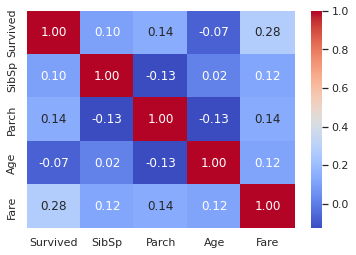

In [21]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = ".2f", cmap="coolwarm")

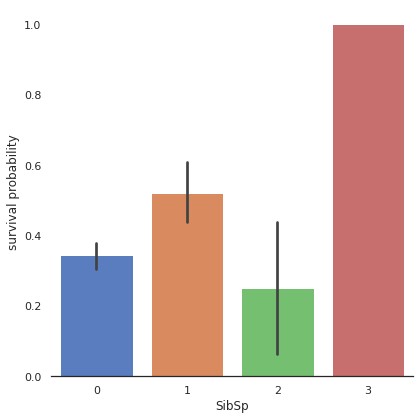

In [23]:
# Explore SibSp featrue vs Survived

g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


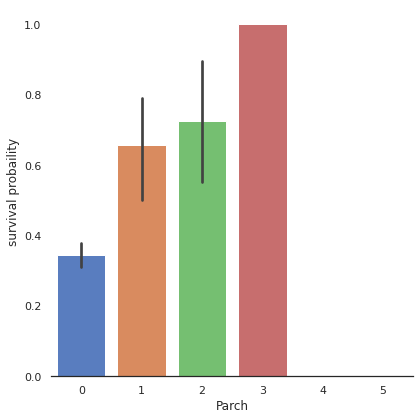

In [26]:
# Explore Parch feature vs Survived

g = sns.factorplot(x = 'Parch', y = 'Survived', data=train, kind='bar', size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels('survival probaility')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


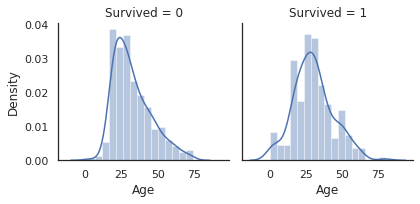

In [27]:
# Explore Age vs Survived

g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

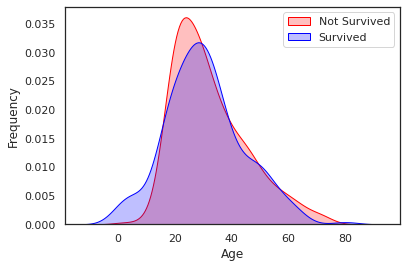

In [29]:
# Explore Age distibution 

g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [30]:
dataset['Fare'].isnull().sum()

1

In [ ]:
# fill fare missing values wi